In [1]:
using Flux

using CSV
using DataFrames

using Random
Random.seed!(42)

df = CSV.read("data1.csv", DataFrame)
x = Matrix(df[:, 1:2])
x = [x[i, :] for i in 1:size(x, 1)]
y = df[:, 3]

X = hcat(x...)
y_train = Flux.onehotbatch(y, unique(y))
y_train = Flux.unstack(y_train',1)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.1.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA C:\Users\Lenovo\.julia\packages\CUDA\s0e3j\src\initialization.jl:70


100-element Vector{Vector{Bool}}:
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 [1, 0, 0, 0]
 ⋮
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]
 [0, 0, 0, 1]

In [2]:
data = zip(x,y_train)
n_hidden = 3
D = size(X,1)
out_dim = length(unique(y))
nn = Chain(
    Dense(D, n_hidden, σ),
    Dense(n_hidden, out_dim)
)  
loss(x, y) = Flux.Losses.logitcrossentropy(nn(x), y)

loss (generic function with 1 method)

In [3]:
using Flux.Optimise: update!, Adam
using Statistics
opt = Adam()
epochs = 200
avg_loss(data) = mean(map(d -> loss(d[1],d[2]), data))
show_every = epochs/10

for epoch = 1:epochs
    for d in data
        gs = gradient(Flux.params(nn)) do
            l = loss(d...)
        end
        update!(opt, Flux.params(nn), gs)
    end
    if epoch % show_every == 0
        println("Epoch " * string(epoch))
        @show avg_loss(data)
    end
end

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 3, σ)    # 9 parameters
│   summary(x) = "2-element Vector{Float64}"
└ @ Flux C:\Users\Lenovo\.julia\packages\Flux\FWgS0\src\layers\stateless.jl:50


Epoch 20
avg_loss(data) = 0.8426136f0
Epoch 40
avg_loss(data) = 0.42556396f0
Epoch 60
avg_loss(data) = 0.22512102f0
Epoch 80
avg_loss(data) = 0.121795416f0
Epoch 100
avg_loss(data) = 0.06675235f0
Epoch 120
avg_loss(data) = 0.037058137f0
Epoch 140
avg_loss(data) = 0.020915324f0
Epoch 160
avg_loss(data) = 0.011952225f0
Epoch 180
avg_loss(data) = 0.006888579f0
Epoch 200
avg_loss(data) = 0.003997504f0


In [4]:
py_layer1 = [[-2.7541,  0.5183],
         [ 3.5415,  0.1424],
         [ 0.1192, -4.3529]]

py_layer1 = hcat(py_layer1...)
py_layer1 = py_layer1'

py_layer2 = [-0.9672,  1.5726, -2.0302]

py_layer3 = [[-5.3452,  2.9503, -8.0299],
         [ 0.5926, -7.3648,  4.3767],
         [-5.9890,  0.3879,  3.8754],
         [ 3.0135, -6.8771, -7.4405]]
py_layer3 = hcat(py_layer3...)
py_layer3 = py_layer3'

py_layer4 = [ 1.5361, -1.5164, -1.5870,  1.8060]

4-element Vector{Float64}:
  1.5361
 -1.5164
 -1.587
  1.806

In [5]:
Flux.params(nn)[1] .= py_layer1
Flux.params(nn)[2] .= py_layer2
Flux.params(nn)[3] .= py_layer3
Flux.params(nn)[4] .= py_layer4

4-element Vector{Float32}:
  1.5361
 -1.5164
 -1.587
  1.806

In [6]:
using LaplaceRedux
la = Laplace(nn; likelihood=:classification)
fit!(la, data)
optimize_prior!(la; verbose=true, n_steps=1000)

[ Info: Precompiling LaplaceRedux [c52c1a26-f7c5-402b-80be-ba1e638ad478]
[ Info: Iteration 100: P₀=0.024387528284082423, σ=1.0


loss(exp.(logP₀), exp.(logσ)) = 5.225724918534424
Log likelihood: -0.3166468588169664
Log det ratio: 0.16987932421859853
Scatter: 9.648276795216317
loss(exp.(logP₀), exp.(logσ)) = 2.5847279578021363
Log likelihood: -0.3166468588169664
Log det ratio: 0.37757343933127174
Scatter: 4.158588758639068


[ Info: Iteration 200: P₀=0.010511483358713452, σ=1.0
[ Info: Iteration 300: P₀=0.006345821849007957, σ=1.0


loss(exp.(logP₀), exp.(logσ)) = 1.8707128176411052
Log likelihood: -0.3166468588169664
Log det ratio: 0.5975763181157845
Scatter: 2.510555599532493
loss(exp.(logP₀), exp.(logσ)) = 1.617044902659642
Log likelihood: -0.3166468588169664
Log det ratio: 0.7984321029075261
Scatter: 1.8023639847778252
loss(exp.(logP₀), exp.(logσ)) = 1.520597332424026
Log likelihood: -0.3166468588169664
Log det ratio: 0.9621439826181302
Scatter: 1.4457569645959891


[ Info: Iteration 400: P₀=0.004555756804030954, σ=1.0
[ Info: Iteration 500: P₀=0.0036543767985051183, σ=1.0
[ Info: Iteration 600: P₀=0.0031640551414875316, σ=1.0


loss(exp.(logP₀), exp.(logσ)) = 1.4843351425430669
Log likelihood: -0.3166468588169664
Log det ratio: 1.083602322650023
Scatter: 1.251774244802178
loss(exp.(logP₀), exp.(logσ)) = 1.4713859137607417
Log likelihood: -0.3166468588169664
Log det ratio: 1.1666005865404543
Scatter: 1.1428775233470962
loss(exp.(logP₀), exp.(logσ)) = 1.4671015202749729
Log likelihood: -0.3166468588169664
Log det ratio: 1.2192156866685764
Scatter: 1.0816936362474365
loss(exp.(logP₀), exp.(logσ)) = 1.4658108106978527
Log likelihood: -0.3166468588169664
Log det ratio: 1.2502819148141668
Scatter: 1.0480459889476055


[ Info: Iteration 700: P₀=0.002888801650019876, σ=1.0
[ Info: Iteration 800: P₀=0.002734149808158036, σ=1.0
[ Info: Iteration 900: P₀=0.0026491001181839346, σ=1.0


loss(exp.(logP₀), exp.(logσ)) = 1.4654614240978217
Log likelihood: -0.3166468588169664
Log det ratio: 1.2673980232241888
Scatter: 1.0302311073375219


[ Info: Iteration 1000: P₀=0.0026040702192325583, σ=1.0


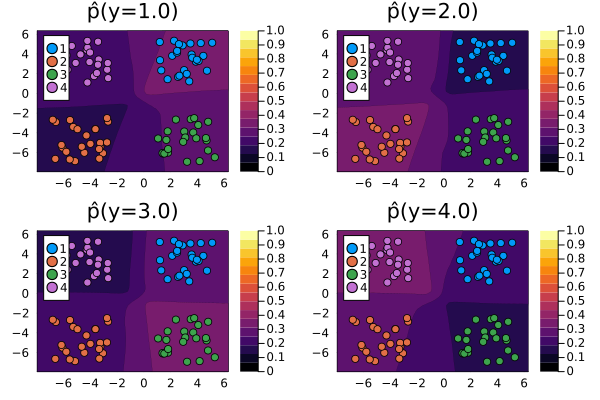

In [7]:
using Plots
_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1))
    push!(plt_list, plt)
end
plot(plt_list...)

In [8]:
predictions_probit = reduce(hcat, predict(la, X))
predictions_probit = reshape(predictions_probit, 4, 100)

4×100 Matrix{Float64}:
 0.366808  0.370646  0.369327  0.370629  …  0.213764  0.213815  0.213823
 0.165418  0.164625  0.164999  0.164635     0.25195   0.251917  0.251914
 0.258953  0.257922  0.25797   0.257909     0.170679  0.170705  0.170708
 0.208821  0.206807  0.207704  0.206827     0.363607  0.363563  0.363555

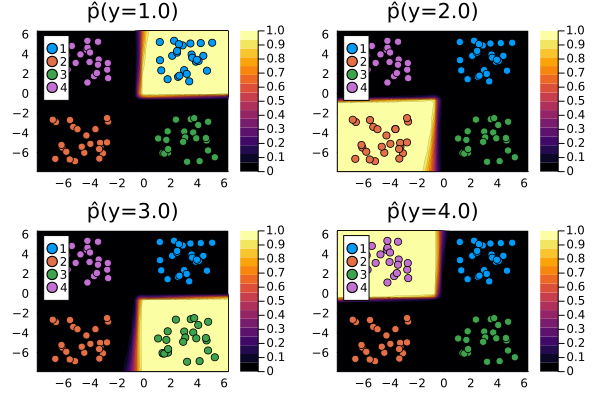

In [9]:
_labels = sort(unique(y))
plt_list = []
for target in _labels
    plt = plot(la, X, y; target=target, clim=(0,1), link_approx=:plugin)
    push!(plt_list, plt)
end
plot(plt_list...)

In [10]:
predictions_plugin = reduce(hcat, predict(la, X, link_approx=:plugin))
predictions_plugin = reshape(predictions_plugin, 4, 100)

4×100 Matrix{Float32}:
 0.996563    0.996545    0.996557    0.996545    …  0.000179636  0.000179702
 1.67368f-6  1.56004f-6  1.63622f-6  1.56281f-6     0.00319589   0.00319497
 0.00335778  0.00338301  0.00336643  0.0033827      4.15063f-6   4.15065f-6
 7.77687f-5  7.0451f-5   7.53181f-5  7.0618f-5      0.99662      0.996621

In [11]:
fμ, fvar = glm_predictive_distribution(la, X)

(Float32[4.4230905 4.4861655 … -3.8057652 -3.8058739; -8.873953 -8.881174 … -0.92707694 -0.9278417; -1.2699403 -1.1993628 … -7.5734377 -7.5739107; -5.0352383 -5.0709677 … 4.815427 4.81495], [680.6142362793119 628.7101173255631 … 731.8102081809277 731.8694165242445; 721.3431090865714 721.6309772604989 … 602.9783243533445 603.0793665152494; 669.9050482350781 604.8666812802444 … 721.0211085669844 721.0695430659282; 747.8632003526772 732.2148391888721 … 625.0684931354428 625.1631924286664])

In [12]:
@show fμ

fμ = Float32[4.4230905 4.4861655 4.443675 4.4846125 4.47784 4.4863772 4.4811244 4.48633 4.4823694 4.4666667 4.467781 3.5401263 4.4663687 4.484477 4.4861603 4.4855537 4.4857717 4.4507 4.4862556 4.4852805 4.486302 4.2991424 4.093085 4.4861827 4.4781938 -11.799243 -11.838917 -11.834752 -11.838986 -11.8357115 -11.838877 -11.837499 -11.838356 -11.838062 -11.808887 -11.810715 -11.768565 -11.83857 -11.838655 -11.838894 -11.815748 -11.813026 -11.837778 -11.834674 -11.838964 -11.747203 -11.794497 -11.838061 -11.83899 -11.838994 -3.543088 -3.543589 -3.5435596 -3.5428138 -3.543511 -3.5545402 -3.5557952 -3.580336 -3.5435 -3.546916 -3.546565 -3.551259 -3.5464602 -3.5434732 -3.5435047 -3.5435853 -3.547504 -3.5435004 -3.5435252 -3.543376 -3.5439534 -3.543501 -3.5483208 -3.5434995 -3.5435004 -3.8091002 -3.8091002 -3.8087373 -3.8090997 -3.809082 -3.8091002 -3.8090506 -3.8091002 -3.8091154 -3.8090796 -3.814241 -3.8091211 -3.808866 -3.809083 -3.8092012 -3.8129888 -3.8087482 -3.809095 -3.8088136 -3.809098

4×100 Matrix{Float32}:
  4.42309   4.48617   4.44368   4.48461  …  -3.8091  -3.80577   -3.80587
 -8.87395  -8.88117  -8.876    -8.88095     -0.9238  -0.927077  -0.927842
 -1.26994  -1.19936  -1.24678  -1.20101     -7.576   -7.57344   -7.57391
 -5.03524  -5.07097  -5.04667  -5.07015      4.8195   4.81543    4.81495

In [13]:
@show fvar

fvar = [680.6142362793119 628.7101173255631 642.3853215173497 628.7253662180203 629.6367597487606 628.7090021261838 628.7691547882912 628.7090961220288 628.7512035016487 633.5690631130315 631.8929493052053 7465.704544381289 632.6244874540972 628.7648154325141 628.7096379346765 628.7173441083694 628.7132777298897 630.9862641491417 628.709225213848 628.7115151308799 628.7086399711534 725.6513106491807 1314.1749477744809 628.709563974285 629.0049200345368 1094.3068610253524 1090.6160417106603 1090.205021859496 1090.623729748576 1090.3339424625135 1090.6089773123429 1090.4602050983228 1090.541765001511 1090.5528926912702 1100.3894971207114 1090.609892816885 1167.9658613995657 1090.59051899564 1090.5797187611038 1090.6107405045586 1094.8512349087823 1098.1794296163212 1090.546645353243 1090.2015505782233 1090.6205640437056 1180.932537456635 1125.992474518092 1090.5040302317866 1090.6242752440733 1090.6248231281766 972.7999531103742 972.8343872367943 972.8353922971173 972.7798572105289 972.8

4×100 Matrix{Float64}:
 680.614  628.71   642.385  628.725  …  731.571  732.113  731.81   731.869
 721.343  721.631  721.134  721.606     602.749  603.169  602.978  603.079
 669.905  604.867  621.968  604.883     720.79   721.326  721.021  721.07
 747.863  732.215  735.963  732.197     624.851  625.266  625.068  625.163

In [14]:
@show la.H

la.H = [2.777952796359823e-8 3.4253090513401583e-10 -8.359633650449404e-10 8.955280163251107e-8 -2.167257388899235e-9 -2.7256323885803735e-10 2.057090573313563e-8 1.9371356907607247e-10 -1.482303588921945e-10 -3.1860142913599044e-8 1.1231309467357082e-7 4.404559268666672e-8 -1.2449660647828902e-7 6.417210081011852e-7 2.906526948785133e-8 -6.806596990289247e-7 9.873698528295985e-9 7.256231188513842e-8 -1.769591347272891e-9 -9.18399034622596e-8 2.1049690683354266e-8 6.502325080111131e-7 1.4028173056783878e-7 -6.712801859854536e-7 -1.192318079687165e-7; 3.4253090513401583e-10 1.4515509888137486e-9 -2.0556726586431119e-10 -2.167257369071102e-9 2.40084572760841e-9 -1.8453021504746343e-10 1.9371362363824886e-10 1.1294824222481408e-9 -5.069795330984056e-11 1.8325072038673725e-8 4.244237652971668e-8 -2.9499893600699446e-8 -3.1267734800558936e-8 1.6432340809820524e-7 -2.6118365841811336e-8 -1.2714195722231207e-7 -1.1062812510390941e-8 -6.427388755625658e-8 2.0214934026318447e-8 7.79236397822433

25×25 Matrix{Float64}:
  2.77795e-8    3.42531e-10  -8.35963e-10  …  -6.7128e-7    -1.19232e-7
  3.42531e-10   1.45155e-9   -2.05567e-10     -1.39412e-7   -4.1326e-8
 -8.35963e-10  -2.05567e-10   4.40999e-8       7.40599e-7    9.86e-7
  8.95528e-8   -2.16726e-9   -2.72563e-10      3.59105e-8    2.78357e-7
 -2.16726e-9    2.40085e-9   -1.8453e-10      -9.61931e-7   -8.44824e-8
 -2.72563e-10  -1.8453e-10    2.57869e-9   …   2.87508e-7   -9.88615e-8
  2.05709e-8    1.93714e-10  -1.4823e-10      -3.48216e-7    5.73709e-8
  1.93714e-10   1.12948e-9   -5.0698e-11      -9.2708e-8     1.78058e-9
 -1.4823e-10   -5.0698e-11    8.69976e-10      2.1611e-7    -1.99551e-7
 -3.18601e-8    1.83251e-8   -4.26909e-8      -3.44942e-6   -1.53015e-5
  1.12313e-7    4.24424e-8   -9.88018e-7   …  -6.05793e-5   -0.000444777
  4.40456e-8   -2.94999e-8    5.81576e-8       1.90047e-5    4.50239e-5
 -1.24497e-7   -3.12677e-8    9.72547e-7       4.50239e-5    0.000415052
  6.41721e-7    1.64323e-7   -6.83205e-7   

In [15]:
@show la.P₀

la.P₀ = [0.0026040702192325583 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0026040702192325583 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0026040702192325583 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0026040702192325583 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0026040702192325583 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0026040702192325583 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0026040702192325583 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0026040702192325583 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.00260

25×25 LinearAlgebra.Diagonal{Float64, Vector{Float64}}:
 0.00260407   ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅          0.00260407   ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅          0.00260407      ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅      

In [16]:
using LaplaceRedux.Curvature
𝐉, fμ = Curvature.jacobians(la.curvature, X)
@show 𝐉

𝐉 = Float32[-0.14119485 0.015653683 -0.15820098 0.07960238 -0.0009967678 0.000110507484 -0.0011168229 0.0005619546 -0.08937385 0.009908505 -0.100138426 0.050386902 -0.005192535 0.00057567464 -0.0058179474 0.002927431 -0.024760598 0.002745104 -0.027742874 0.013959451 -0.00011513274 1.2764285f-5 -0.00012899983 6.4909174f-5 -0.010799108 0.001197252 -0.012099801 0.0060882866 -0.00031217618 3.460967f-5 -0.0003497761 0.00017599772 -0.009029919 0.0010011094 -0.010117522 0.005090859 -0.051462125 0.00570539 -0.057660453 0.029013151 -0.045902018 0.005088965 -0.05143066 0.025878496 -0.92235523 0.10225768 -1.0334479 0.52000254 -0.049506847 0.005488617 -0.05546967 0.027910812 -0.006684909 0.00074112794 -0.0074900696 0.0037687968 -0.00092512125 0.00010256433 -0.001036547 0.00052156195 -0.0030151065 0.00033427228 -0.0033782595 0.0016998473 -0.002267709 0.0002514114 -0.002540842 0.0012784818 -0.056829907 0.0063004945 -0.063674755 0.032039385 -0.00058504485 6.486147f-5 -0.00065551023 0.0003298347 -0.00

25×400 Matrix{Float32}:
 -0.141195      0.0156537    -0.158201     …   0.00509061   -0.00256146
  0.000216224  -0.000539758   2.84287f-5      -0.000548177   0.00971866
 -2.52577f-10   1.37667f-10   1.21899f-10     -1.5487f-6     2.9734f-6
 -0.333466      0.03697      -0.37363         -0.00579139    0.00291407
  0.000510666  -0.00127477    6.71414f-5       0.000623639  -0.0110565
 -5.96522f-10   3.25135f-10   2.87894f-10  …   1.7619f-6    -3.38272f-6
 -0.0624663     0.00692538   -0.06999         -0.00188493    0.000948447
  9.56602f-5   -0.000238795   1.25772f-5       0.000202977  -0.00359859
 -1.11743f-10   6.09057f-11   5.39296f-11      5.73448f-7   -1.10098f-6
  0.0118263     0.0           0.0              0.0           0.0
  0.0           0.0118263     0.0          …   0.0           0.0
  0.0           0.0           0.0118263        0.999685      0.0
  0.0           0.0           0.0              0.0           0.999685
  0.999968      0.0           0.0              0.0           0.0